In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Quick data visualization

First let's see how our images look like:

📂 Classes détectées : ['train', 'test']


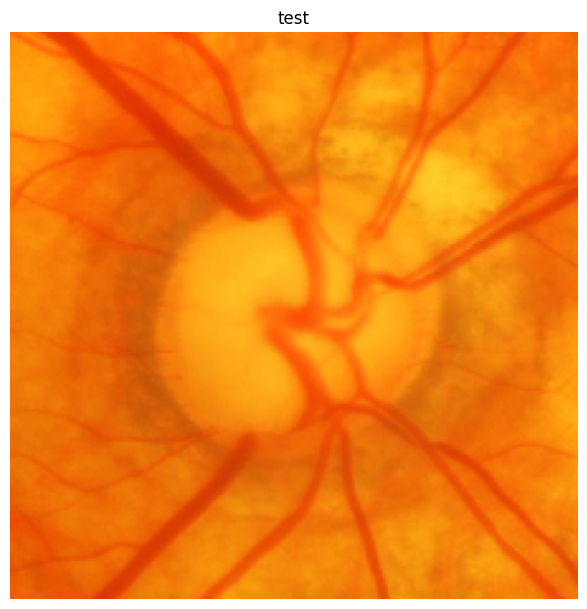

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img



base_path = "/content/drive/My Drive/acrima"


classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]


if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0

    # Afficher une image par classe
    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name)  # Prendre uniquement les images
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue

        # Lister les fichiers images
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(224, 224))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


In [ ]:

for expression in os.listdir(base_path + "/train"):
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

326 Glaucoma images
239 Non Glaucoma images


In [ ]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📂 Chemin du dossier d'entraînement
train_dir = "/content/drive/My Drive/acrima/train"

classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 224
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


Found 478 validated image filenames belonging to 2 classes.
📊 Nouvelle distribution des classes :
 class
Glaucoma        239
Non Glaucoma    239
Name: count, dtype: int64


<ipython-input-18-eaed69ba74d9>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


The image expressions in our training dataset are pretty balanced, except for the 'disgust' category.

Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).


In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,895,301 (64.45 MB)

 Trainable params: 5,631,617 (21.48 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 11,263,236 (42.97 MB)

Fold 1/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5435 - loss: 2.0588 - val_accuracy: 0.7917 - val_loss: 1.7791
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5932 - loss: 1.7434 - val_accuracy: 0.8125 - val_loss: 1.5806
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6955 - loss: 1.5254 - val_accuracy: 0.8229 - val_loss: 1.4158
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7000 - loss: 1.3832 - val_accuracy: 0.8333 - val_loss: 1.2777
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7222 - loss: 1.2541 - val_accuracy: 0.8125 - val_loss: 1.1706
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7377 - loss: 1.1578 - val_accuracy: 0.8333 - val_loss: 1.0720
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7616 - loss: 1.0438 - val_accuracy: 0.8333 - val_loss: 1.0101
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7854 - loss: 0.9871 - val_accuracy: 0.8333 - v

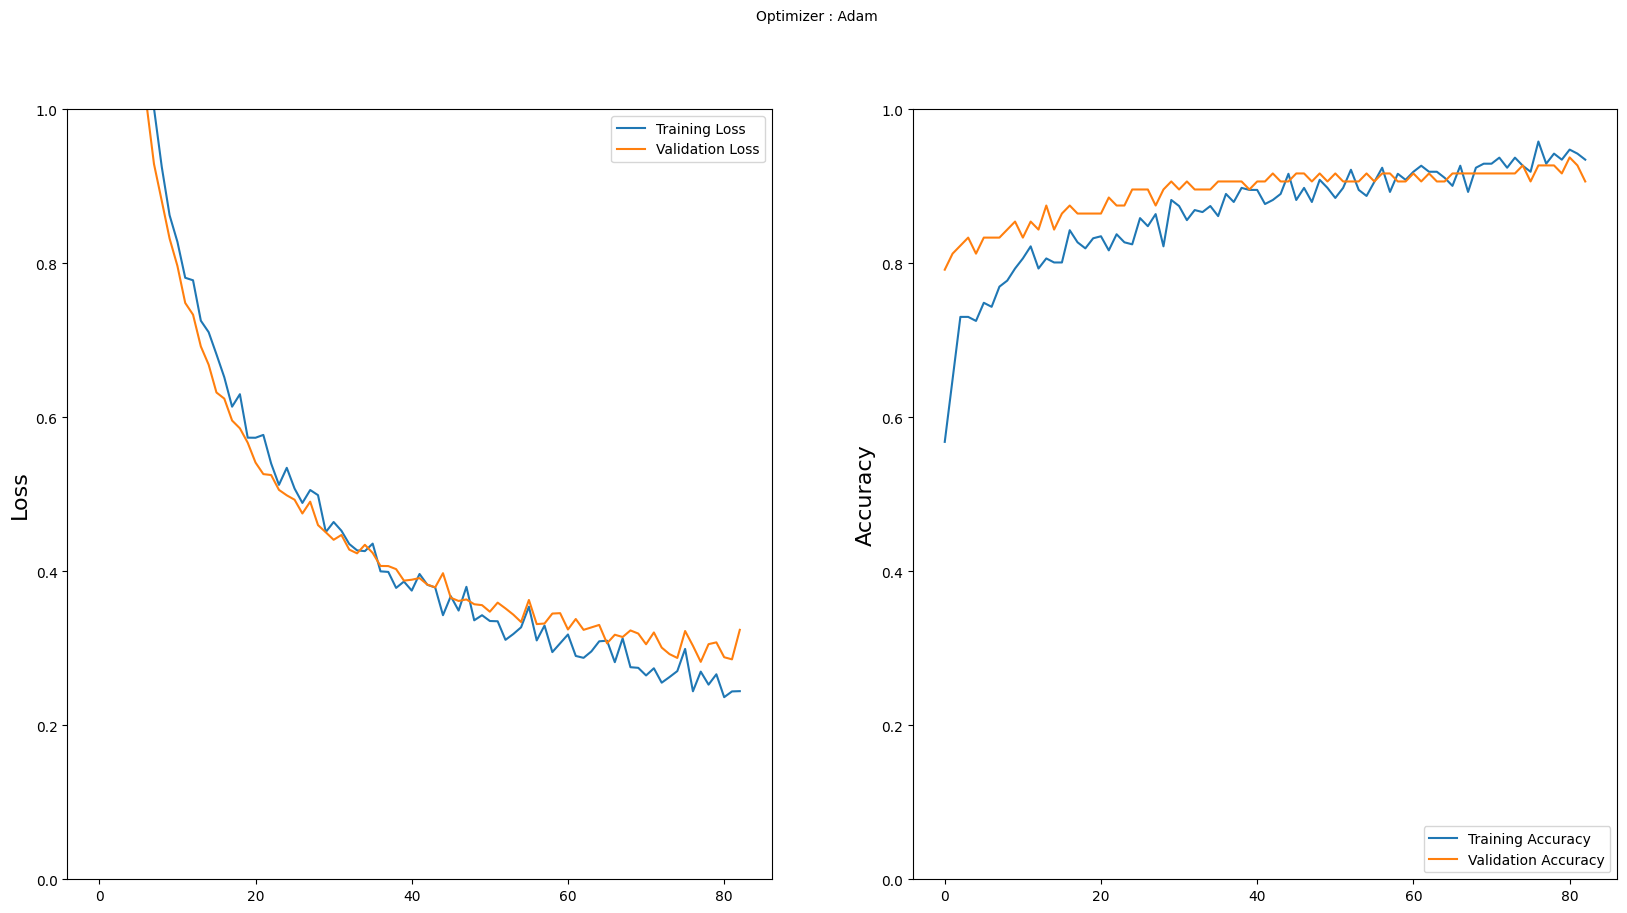

Fold 2/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5765 - loss: 1.9592 - val_accuracy: 0.7500 - val_loss: 1.6820
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7704 - loss: 1.6190 - val_accuracy: 0.8333 - val_loss: 1.4596
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8469 - loss: 1.3719 - val_accuracy: 0.8125 - val_loss: 1.3212
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8330 - loss: 1.2572 - val_accuracy: 0.8542 - val_loss: 1.1908
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8540 - loss: 1.1693 - val_accuracy: 0.8854 - val_loss: 1.1113
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8379 - loss: 1.0920 - val_accuracy: 0.8229 - val_loss: 1.0378
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8370 - loss: 0.9956 - val_accuracy: 0.8229 - val_loss: 1.0433
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8505 - loss: 0.9704 - val_accuracy: 0.8229 - v

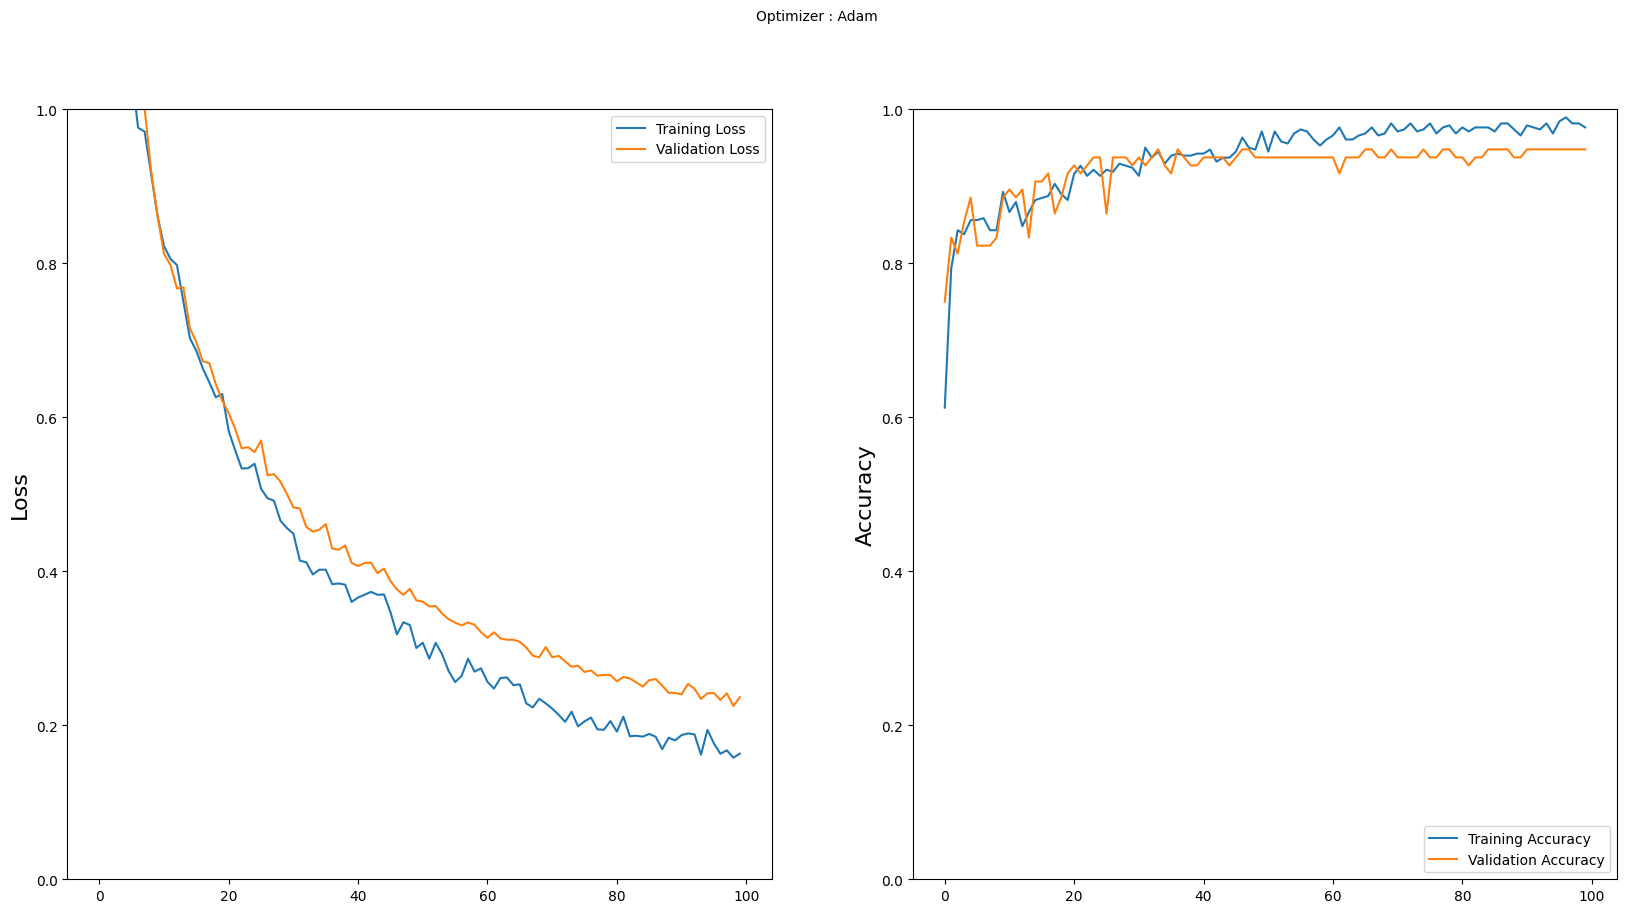

Fold 3/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6130 - loss: 1.9439 - val_accuracy: 0.7917 - val_loss: 1.7427
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5836 - loss: 1.8035 - val_accuracy: 0.8646 - val_loss: 1.5923
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7875 - loss: 1.4912 - val_accuracy: 0.8750 - val_loss: 1.4235
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7639 - loss: 1.3278 - val_accuracy: 0.8750 - val_loss: 1.3035
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8530 - loss: 1.1956 - val_accuracy: 0.8958 - val_loss: 1.2038
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8008 - loss: 1.1746 - val_accuracy: 0.8854 - val_loss: 1.1376
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8468 - loss: 1.0619 - val_accuracy: 0.8958 - val_loss: 1.0597
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8026 - loss: 1.0907 - val_accuracy: 0.8958 - v

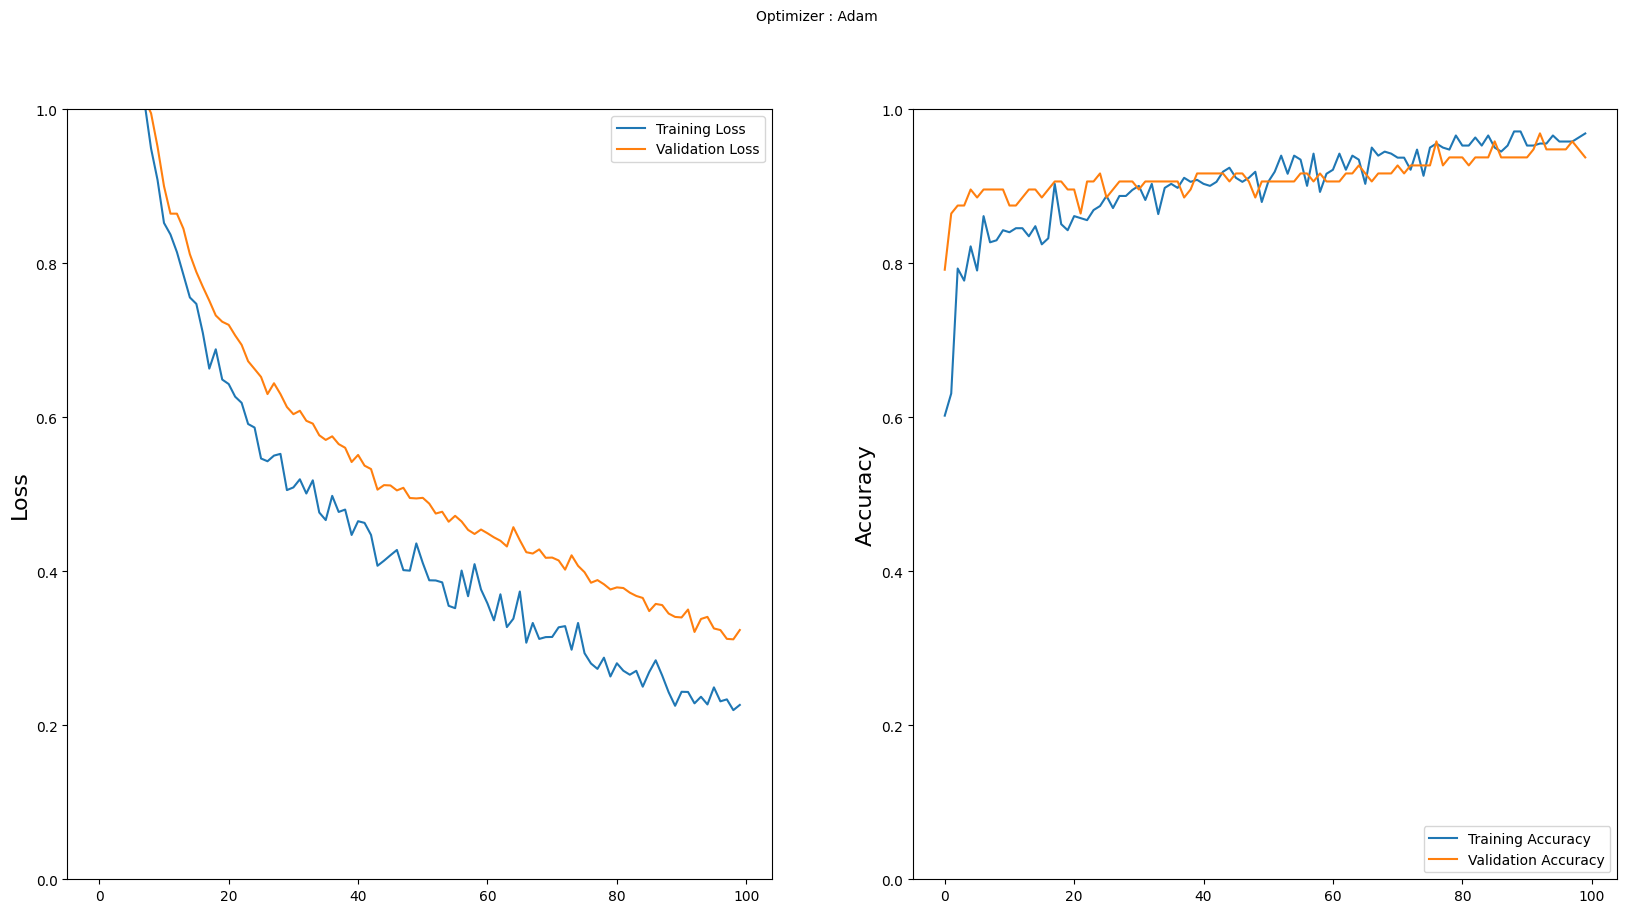

Fold 4/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5766 - loss: 1.9195 - val_accuracy: 0.7579 - val_loss: 1.7368
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7687 - loss: 1.5958 - val_accuracy: 0.8211 - val_loss: 1.5322
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7506 - loss: 1.4845 - val_accuracy: 0.7895 - val_loss: 1.4165
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7920 - loss: 1.3258 - val_accuracy: 0.7368 - val_loss: 1.3262
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7841 - loss: 1.2020 - val_accuracy: 0.7895 - val_loss: 1.2116
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8226 - loss: 1.0633 - val_accuracy: 0.8316 - val_loss: 1.1201
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8142 - loss: 0.9952 - val_accuracy: 0.7895 - val_loss: 1.0689
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8362 - loss: 0.9207 - val_accuracy: 0.8211 - v

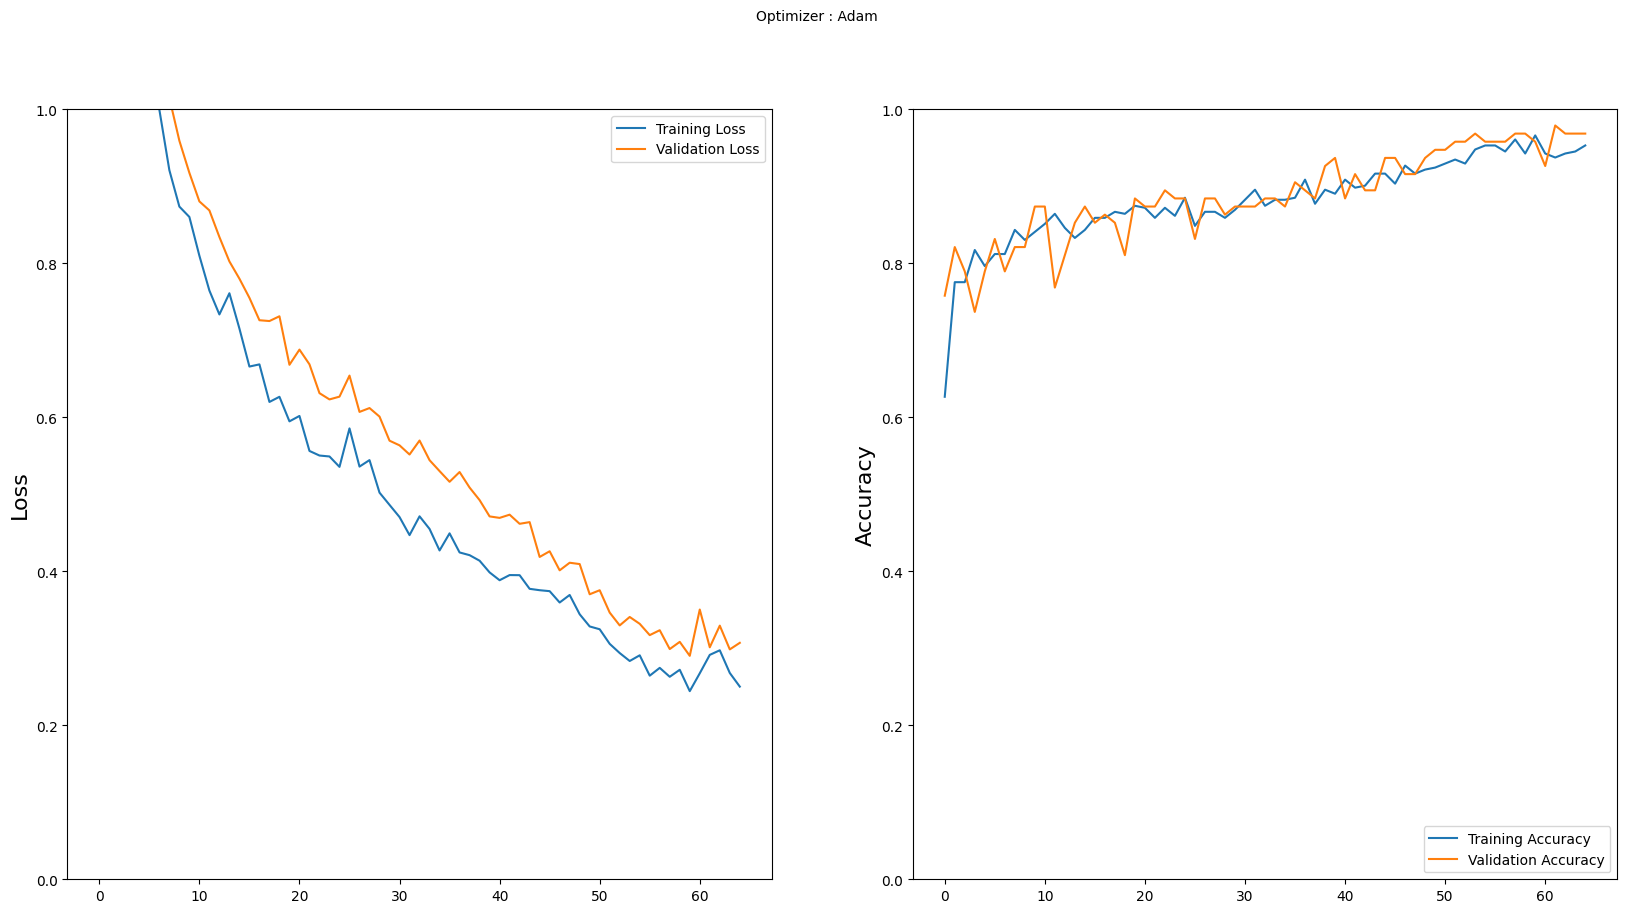

Fold 5/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4966 - loss: 2.1434 - val_accuracy: 0.5263 - val_loss: 1.8082
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5797 - loss: 1.7978 - val_accuracy: 0.7158 - val_loss: 1.6844
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6123 - loss: 1.6148 - val_accuracy: 0.7474 - val_loss: 1.5531
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6801 - loss: 1.4657 - val_accuracy: 0.8000 - val_loss: 1.4567
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7365 - loss: 1.3624 - val_accuracy: 0.7158 - val_loss: 1.3711
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7670 - loss: 1.2548 - val_accuracy: 0.6526 - val_loss: 1.3071
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7566 - loss: 1.1814 - val_accuracy: 0.7789 - val_loss: 1.2449
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7649 - loss: 1.1528 - val_accuracy: 0.7895 - v

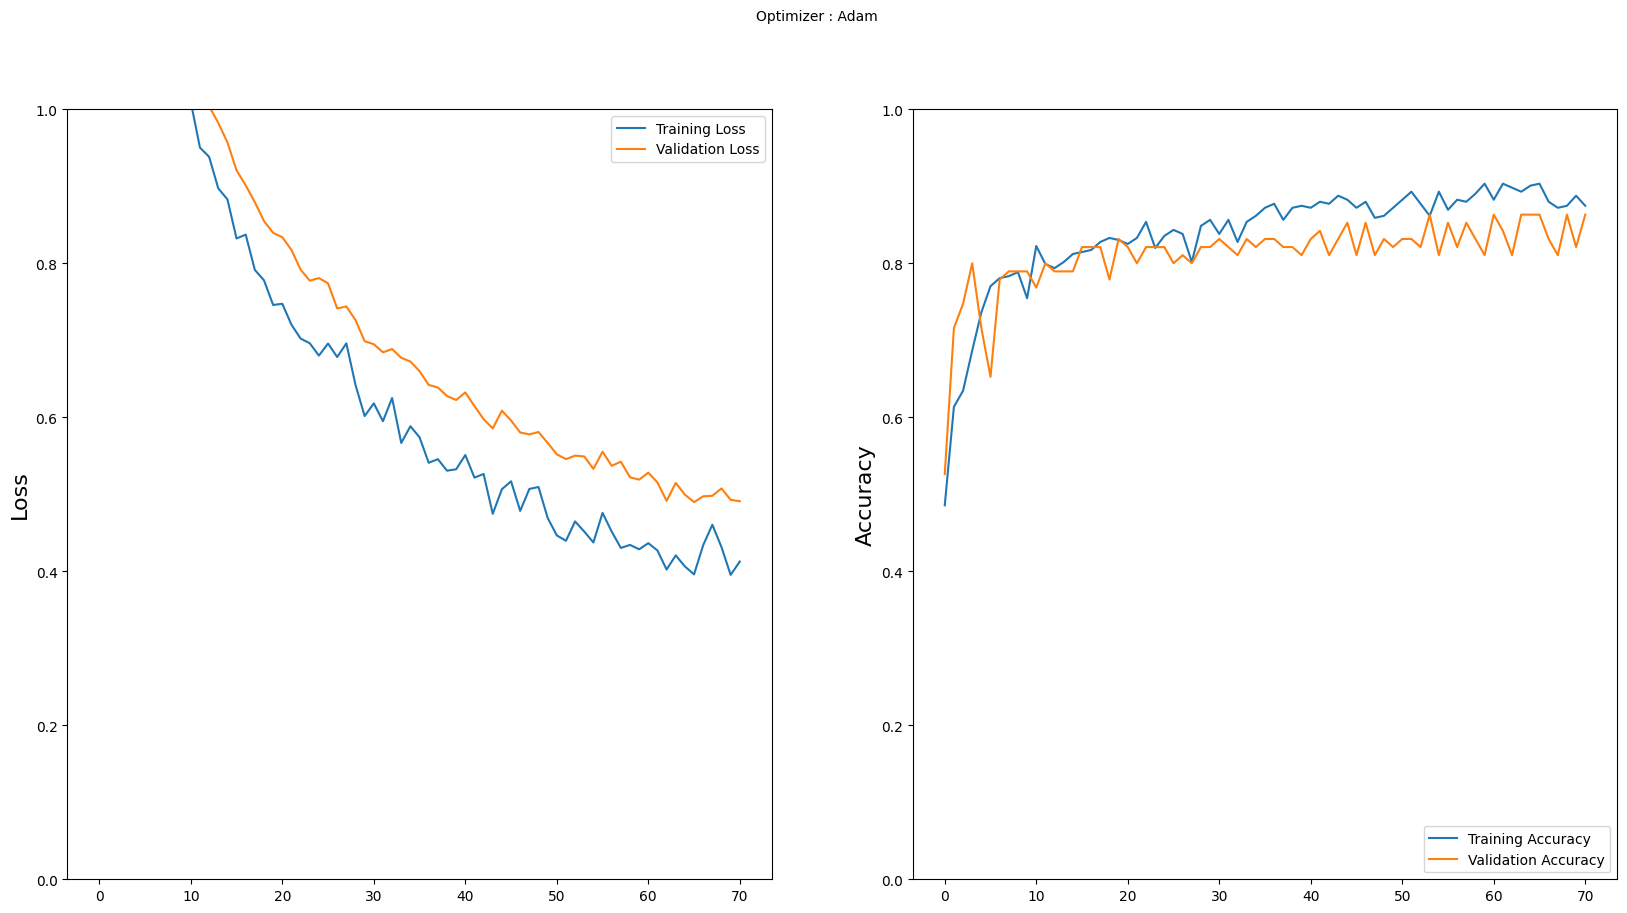

Moyenne des accuracies sur 5 folds: 0.9393


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


input_shape = (224, 224, 3)
batch_size = 32
epochs = 100
k_folds = 5
num_classes = 2

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []


image_dir = "/content/drive/My Drive/acrima/train"

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')


    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]


    train_generator = datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )


    model = Sequential([
      Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
      MaxPooling2D(2,2),
      Dropout(0.4),

      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Dropout(0.5),

      Flatten(),
      Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
      Dropout(0.6),
      Dense(1, activation='sigmoid')
    ])



    model.compile(optimizer = Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )


    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")


    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim([0, 1])


    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.ylim([0, 1])

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

import numpy

print(f'Moyenne des accuracies sur {k_folds} folds: {numpy.mean(fold_accuracies):.4f}')


# Train the model

Everything is set up, let's train our model now!

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

We also have to save the structure of our CNN (layers etc.) into a file:

In [ ]:
model.save('/content/drive/My Drive/glaucome_CNN.hdf5')
print("SAVED")

SAVED


# Analyze the results

We got outputs at each step of the training phase. All those outputs were saved into the 'history' variable. We can use it to plot the evolution of the loss and accuracy on both the train and validation datasets:

The validation accuracy starts to stabilize at the end of the 50 epochs between 60% and 65% accuracy.

The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model.

We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.

Finally we can plot the confusion matrix in order to see how our model classified the images:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/acrima/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='binary',
    shuffle=False
)


Found 140 images belonging to 2 classes.


Found 140 images belonging to 2 classes.
✅ Accuracy: 87.14%


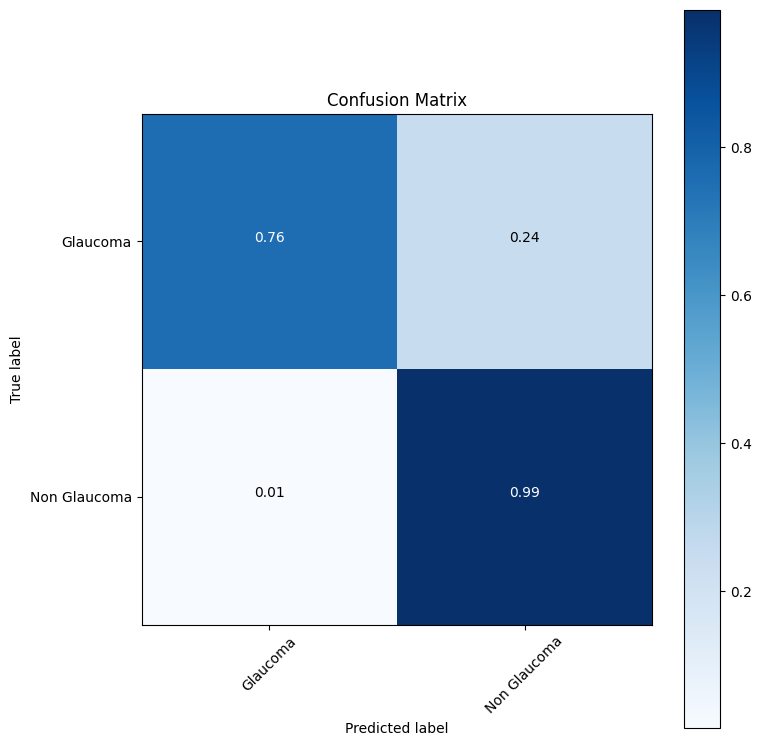

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Affiche la matrice de confusion normalisée"""
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/acrima/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='binary',
    shuffle=False
)

y_pred = []
y_true = []
for i in range(len(test_generator)):
    X_test_batch, y_test_batch = test_generator[i]
    predictions_batch = model.predict(X_test_batch, verbose=0)

    y_pred_batch = (predictions_batch > 0.5).astype(int).flatten()

    y_true_batch = y_test_batch.astype(int)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_true_batch)

y_pred = np.array(y_pred)
y_true = np.array(y_true)


class_names = list(test_generator.class_indices.keys())


cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')